## Preamble

This notebook contains a brief tour of some exploratory analyses that can be performed on large-scale genome variation data using [scikit-allel](http://scikit-allel.readthedocs.org) in combination with general purpose Python scientific libraries such as [numpy](http://numpy.org), [pandas](http://pandas.pydata.org), [matplotlib](http://matplotlib.org), etc.

### Motivation

In the [Ag1000G](http://www.malariagen.net/ag1000g) project (phase 1) we have whole-genome sequence data from 765 individual mosquitoes collected from 8 different countries across Africa. We have used a [standard approach](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3083463/?tool=pmcentrez) to find putative genetic differences between each individual mosquito and the reference genome sequence. The raw (i.e., unfiltered) data on genetic variantion contains more than 90 million single nucleotide polymorphisms (SNPs).

There are a range of analyses we'd like to perform with these data. The raw data are noisy and so we need to identify poor quality features within the data and design filters. After we've dealt with data quality, we would like to learn about the different populations that these mosquitoes came from. For example, are these populations genetically different from each other, and have any genes have come under recent selection (e.g., due to insecticides).

These are rich data and there are many ways they could be explored. The goal of [scikit-allel]() is to help speed up this exploration process by providing a toolkit for data manipulation and descriptive statistics. In particular, we would like to enable interactive analysis of large scale data on commodity hardware. This means that functions should be able to run on ~100 million genetic variants in ~1000 individuals on a moderate spec desktop or laptop computer and return in seconds or at most minutes. I.e., you should be able to analyse data wherever you are (at your desk, on a train, ...) and only the occasional tea break should be required.

### About this tour

The goal of this tour is to give a flavour of:

* What types of analysis are possible
* How much coding is required
* How fast stuff runs

For more information see the Further Reading section below. The raw .ipynb file for this post is available [here](https://github.com/alimanfoo/alimanfoo.github.io/tree/master/_posts).

## Setup

Let's import the libraries we'll be using.

In [1]:
import numpy as np
import scipy
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
import h5py
import allel; print('scikit-allel', allel.__version__)

scikit-allel 1.0.3


The data we'll be analysing originally came from a [VCF format file](https://en.wikipedia.org/wiki/Variant_Call_Format), however these data have previously been pre-processed into an [HDF5 file](https://www.hdfgroup.org/HDF5/) which improves data access speed for a range of access patterns. I won't cover this pre-processing step here, for more information see [vcfnp](https://github.com/alimanfoo/vcfnp). 

Open an HDF5 file containing variant calls from the [Ag1000G project phase 1 AR3 data release](https://www.malariagen.net/data/ag1000g-phase1-ar3). Note that this contains **raw data**, i.e., all putative SNPs are included. As part of the Ag1000G project we have done a detailed analysis of data quality and so this dataset already contains filter annotations to tell you which SNPs we believe are real. However, for the purpose of this tour, I am going to pretend that we have never seen these data before, and so need to perform our own analysis of data quality.

In [2]:
callset_fn = 'data/2016-06-10/ag1000g.phase1.ar3.h5'
callset = h5py.File(callset_fn, mode='r')
callset

<HDF5 file "ag1000g.phase1.ar3.h5" (mode r)>

Pick a chromosome arm to work with.

In [3]:
chrom = '3L'

## Visualize variant density

As a first step into getting to know these data, let's make a plot of variant density, which will simply show us how many SNPs there are and how they are distributed along the chromosome.

The data on SNP positions and various other attributes of the SNPs are stored in the HDF5 file. Each of these can be treated as a column in a table, so let's set up a table with some of the columns we'll need for this and subsequent analyses.

In [4]:
variants = allel.VariantChunkedTable(callset[chrom]['variants'], 
                                     names=['POS', 'REF', 'ALT', 'DP', 'MQ', 'QD', 'num_alleles'],
                                     index='POS')
variants

<VariantChunkedTable shape=(16437135,) dtype=[('POS', '<i4'), ('REF', 'S1'), ('ALT', 'S1', (3,)), ('DP', '<i4'), ('MQ', '<f2'), ('QD', '<f2'), ('num_alleles', 'u1')]
   nbytes=266.5M cbytes=116.8M cratio=2.3
   values=h5py._hl.group.Group>

The caption for this table tells us that we have 16,437,135 SNPs (rows) in this dataset.

Now let's extract the variant positions and load into a numpy array.

In [5]:
pos = variants['POS'][:]
pos

array([      15,       19,       20, ..., 41963184, 41963288, 41963345], dtype=int32)

Define a function to plot variant density in windows over the chromosome.

In [6]:
def plot_windowed_variant_density(pos, window_size, title=None):
    
    # setup windows 
    bins = np.arange(0, pos.max(), window_size)
    
    # use window midpoints as x coordinate
    x = (bins[1:] + bins[:-1])/2
    
    # compute variant density in each window
    h, _ = np.histogram(pos, bins=bins)
    y = h / window_size
    
    # plot
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.despine(ax=ax, offset=10)
    ax.plot(x, y)
    ax.set_xlabel('Chromosome position (bp)')
    ax.set_ylabel('Variant density (bp$^{-1}$)')
    if title:
        ax.set_title(title)


Now make a plot with the SNP positions from our chosen chromosome.

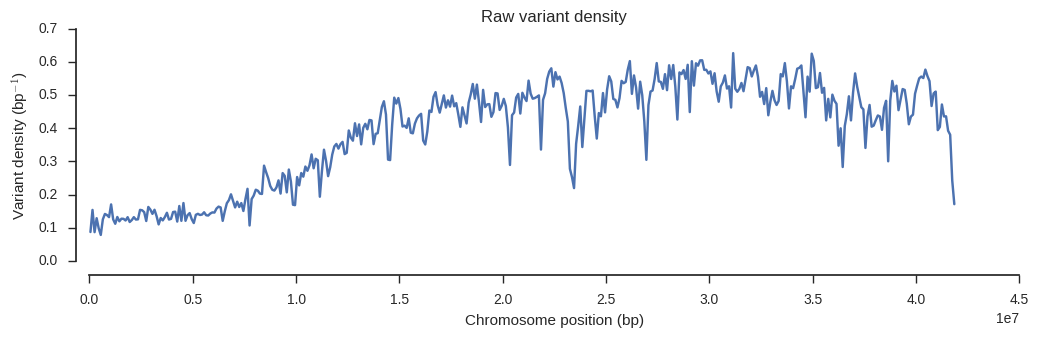

In [7]:
plot_windowed_variant_density(pos, window_size=100000, title='Raw variant density')

From this we can see that variant density is around 0.5 over much of the chromosome, which means the raw data contains a SNP about every 2 bases of the reference genome.

## Explore variant attributes

As I mentioned above, each SNP also has a number "annotations", which are data attributes that originally came from the "INFO" field in the VCF file. These are important for data quality, so let's begin by getting to know a bit more about the numerical range and distribution of some of these attributes.

Each attribute can be loaded from the table we setup earlier into a numpy array. E.g., load the "DP" field into an array.

In [8]:
dp = variants['DP'][:]
dp

array([    1,     2,     2, ..., 10092,  3072,  1485], dtype=int32)

Define a function to plot a frequency distribution for any variant attribute.

In [9]:
def plot_variant_hist(f, bins=30):
    x = variants[f][:]
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.despine(ax=ax, offset=10)
    ax.hist(x, bins=bins)
    ax.set_xlabel(f)
    ax.set_ylabel('No. variants')
    ax.set_title('Variant %s distribution' % f)


"DP" is total depth of coverage across all samples.

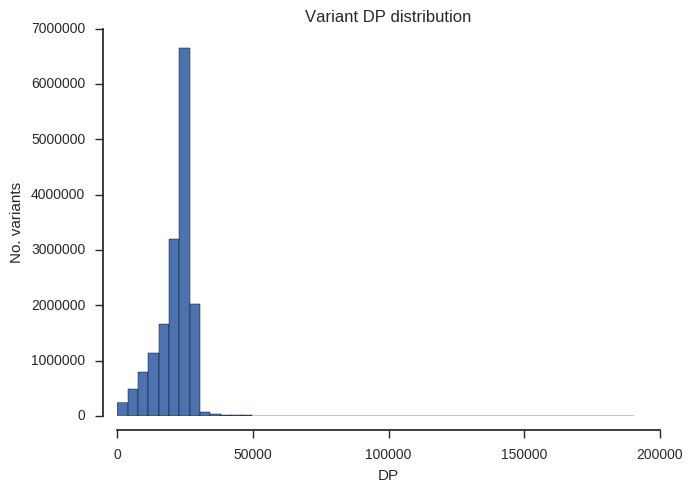

In [10]:
plot_variant_hist('DP', bins=50)

"MQ" is average mapping quality across all samples.

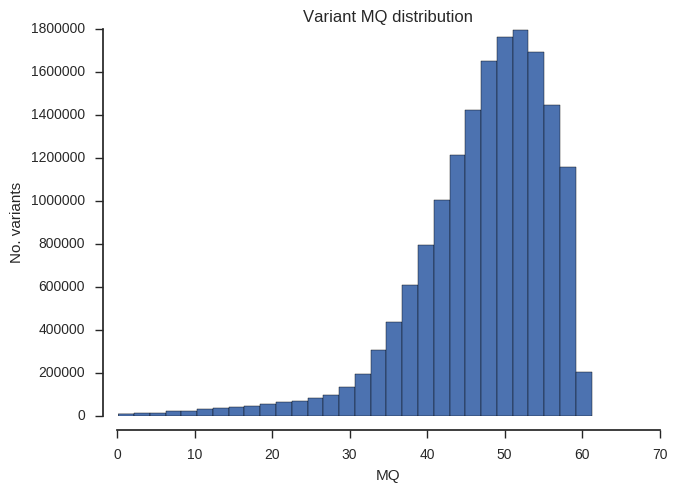

In [11]:
plot_variant_hist('MQ')

"QD" is a slightly odd statistic but turns out to be very useful for finding poor quality SNPs. Roughly speaking, high numbers mean that evidence for variation is strong (concentrated), low numbers mean that evidence is weak (dilute).

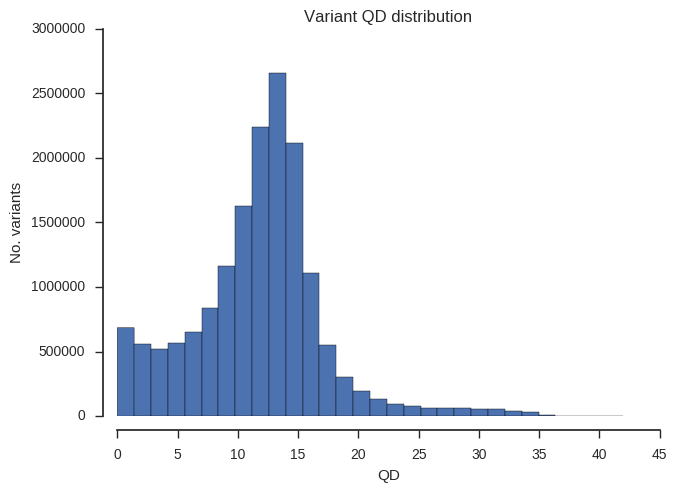

In [12]:
plot_variant_hist('QD')

Finally let's see how many biallelic, triallelic and quadriallelic SNPs we have.

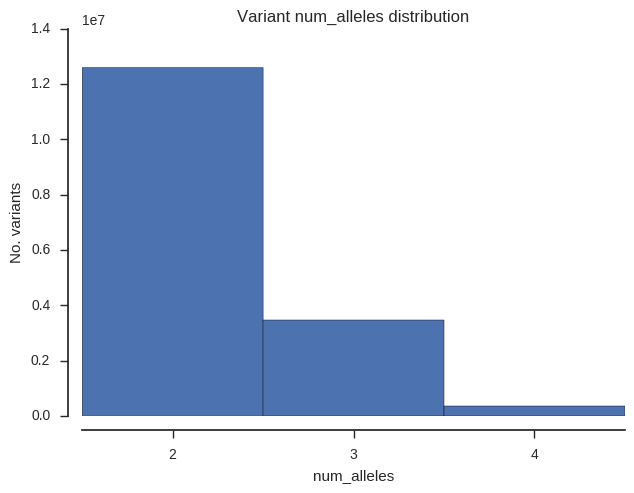

In [13]:
plot_variant_hist('num_alleles', bins=np.arange(1.5, 5.5, 1))
plt.gca().set_xticks([2, 3, 4]);

We can also look at the joint frequency distribution of two attributes.

In [14]:
def plot_variant_hist_2d(f1, f2, downsample):
    x = variants[f1][:][::downsample]
    y = variants[f2][:][::downsample]
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.despine(ax=ax, offset=10)
    ax.hexbin(x, y, gridsize=40)
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_title('Variant %s versus %s joint distribution' % (f1, f2))

To make the plotting go faster I've downsampled to use every 10th variant.

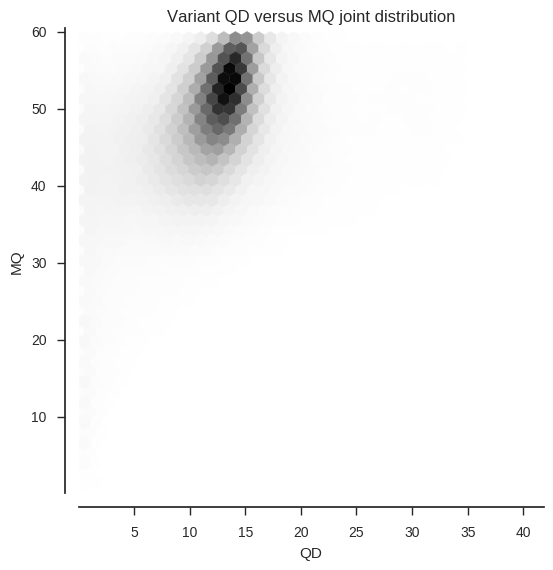

In [15]:
plot_variant_hist_2d('QD', 'MQ', downsample=10)

## Investigate variant quality

The DP, MQ and QD attributes are potentially informative about SNP quality. For example, we have a prior expectation that putative SNPs with very high or very low DP may coincide with some form of larger structural variation, and may therefore be unreliable. However, it would be great to have some empirical indicator of data quality, which could guide our choices about how to filter the data.

There are several possible quality indicators that could be used, and in general it's a good idea to use more than one if available. Here, to illustrate the general idea, let's use just one indicator, which is the number of [transitions]() divided by the number of [transversions](), which I will call Ti/Tv.

![Transitions and transversions](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/Transitions-transversions-v4.svg/500px-Transitions-transversions-v4.svg.png)

If mutations were completely random we would expect a Ti/Tv of 0.5, because there are twice as many possible transversions as transitions. However, in most species a mutation bias has been found towards transitions, and so we expect the true Ti/Tv to be higher. We can therefore look for features of the raw data that are associated with low Ti/Tv (close to 0.5) and be fairly confident that these contain a lot of noise. 

To do this, let's first set up an array of mutations, where each entry contains two characters representing the reference and alternate allele. For simplicity of presentation I'm going to ignore the fact that some SNPs are multiallelic, but if doing this for real this should be restricted to biallelic variants only.

In [16]:
mutations = np.char.add(variants['REF'], variants['ALT'][:, 0])
mutations

array([b'GT', b'AC', b'AG', ..., b'AT', b'AC', b'AT'], 
      dtype='|S2')

Define a function to locate transition mutations within a mutations array.

In [17]:
def locate_transitions(x):
    x = np.asarray(x)
    return (x == b'AG') | (x == b'GA') | (x == b'CT') | (x == b'TC')

Demonstrate how the ``locate_transitions`` function generates a boolean array from a mutations array.

In [18]:
is_ti = locate_transitions(mutations)
is_ti

array([False, False,  True, ..., False, False, False], dtype=bool)

Define a function to compute Ti/Tv.

In [19]:
def ti_tv(x):
    if len(x) == 0:
        return np.nan
    is_ti = locate_transitions(x)
    n_ti = np.count_nonzero(is_ti)
    n_tv = np.count_nonzero(~is_ti)
    if n_tv > 0:
        return n_ti / n_tv
    else:
        return np.nan

Demonstrate the ``ti_tv`` function by computing Ti/Tv over all SNPs.

In [20]:
ti_tv(mutations)

1.0556008127791614

Define a function to plot Ti/Tv in relation to a variant attribute like DP or MQ.

In [21]:
def plot_ti_tv(f, downsample, bins):
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.despine(ax=ax, offset=10)
    x = variants[f][:][::downsample]
    
    # plot a histogram
    ax.hist(x, bins=bins)
    ax.set_xlabel(f)
    ax.set_ylabel('No. variants')

    # plot Ti/Tv
    ax = ax.twinx()
    sns.despine(ax=ax, bottom=True, left=True, right=False, offset=10)
    values = mutations[::downsample]
    with np.errstate(over='ignore'):
        # binned_statistic generates an annoying overflow warning which we can ignore
        y1, _, _ = scipy.stats.binned_statistic(x, values, statistic=ti_tv, bins=bins)
    bx = (bins[1:] + bins[:-1]) / 2
    ax.plot(bx, y1, color='k')
    ax.set_ylabel('Ti/Tv')
    ax.set_ylim(0.6, 1.3)

    ax.set_title('Variant %s and Ti/Tv' % f)


Example the relationship between the QD, MQ and DP attributes and Ti/Tv. 

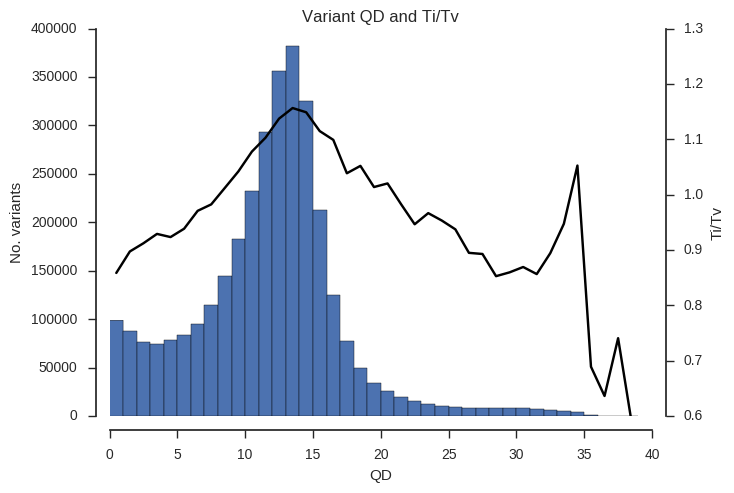

In [22]:
plot_ti_tv('QD', downsample=5, bins=np.arange(0, 40, 1))

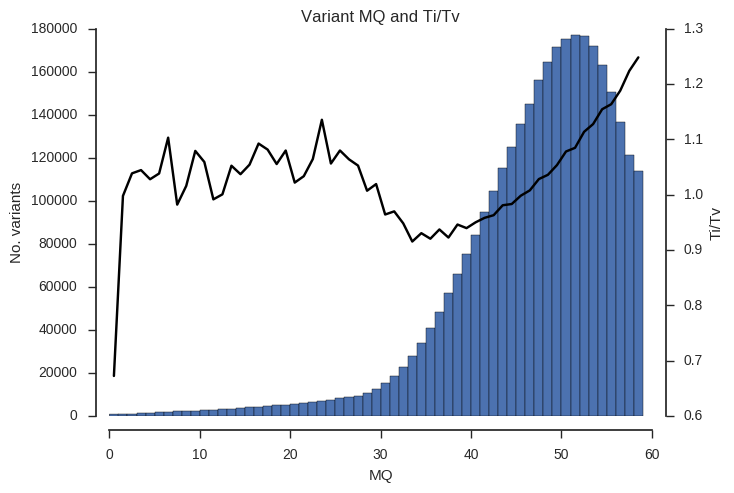

In [23]:
plot_ti_tv('MQ', downsample=5, bins=np.arange(0, 60, 1))

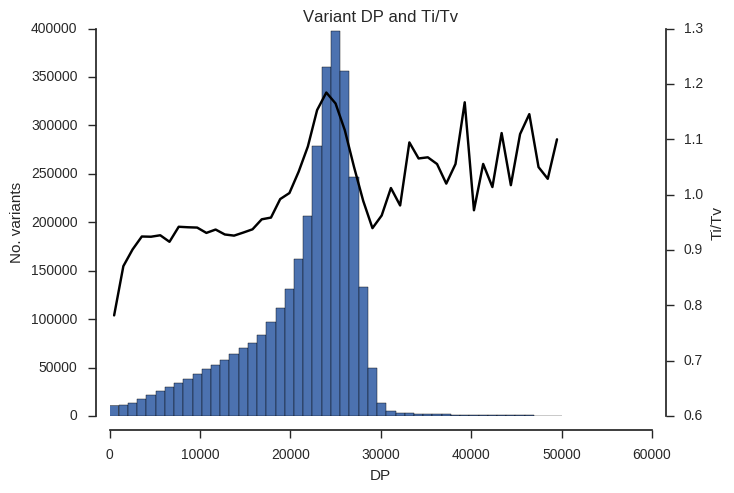

In [24]:
plot_ti_tv('DP', downsample=5, bins=np.linspace(0, 50000, 50))

Ti/Tv is not a simple variable and so some care is required when interpreting these plots. However, we can see that there is a trend towards low Ti/Tv for low values of QD, MQ and DP.

To investigate further, let's look at Ti/Tv in two dimensions. 

In [25]:
def plot_joint_ti_tv(f1, f2, downsample, gridsize=20, mincnt=20, vmin=0.6, vmax=1.4, extent=None):
    fig, ax = plt.subplots()
    sns.despine(ax=ax, offset=10)
    x = variants[f1][:][::downsample]
    y = variants[f2][:][::downsample]
    C = mutations[::downsample]
    im = ax.hexbin(x, y, C=C, reduce_C_function=ti_tv, mincnt=mincnt, extent=extent,
                   gridsize=gridsize, cmap='jet', vmin=vmin, vmax=vmax)
    fig.colorbar(im)
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_title('Variant %s versus %s and Ti/Tv' % (f1, f2))

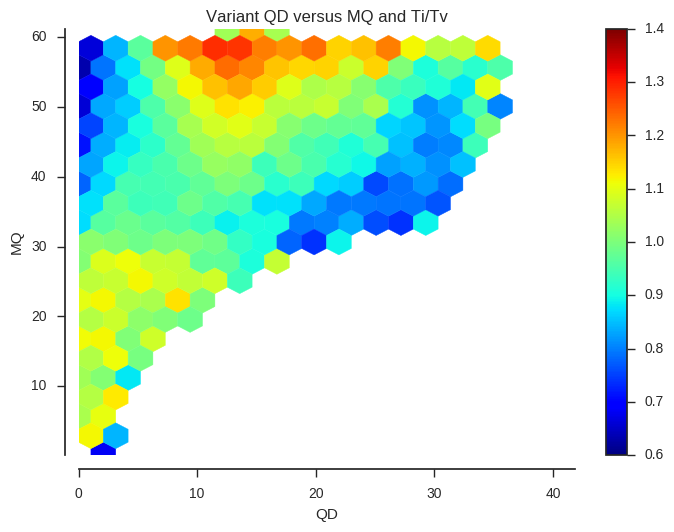

In [26]:
plot_joint_ti_tv('QD', 'MQ', downsample=5, mincnt=400)

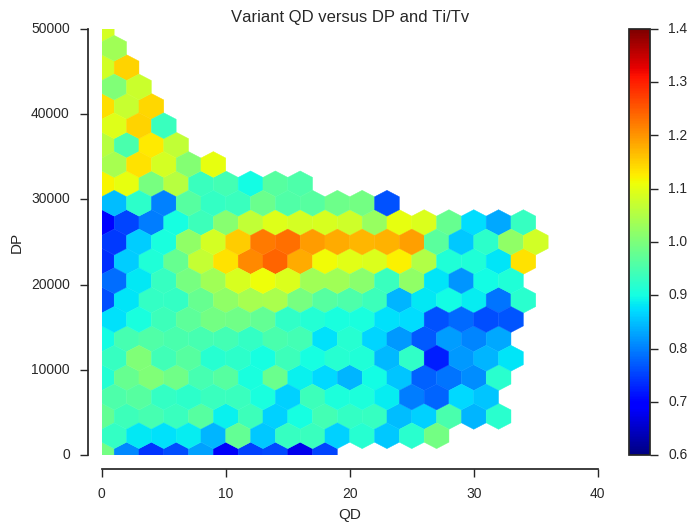

In [27]:
plot_joint_ti_tv('QD', 'DP', downsample=5, mincnt=400, extent=(0, 40, 0, 50000))

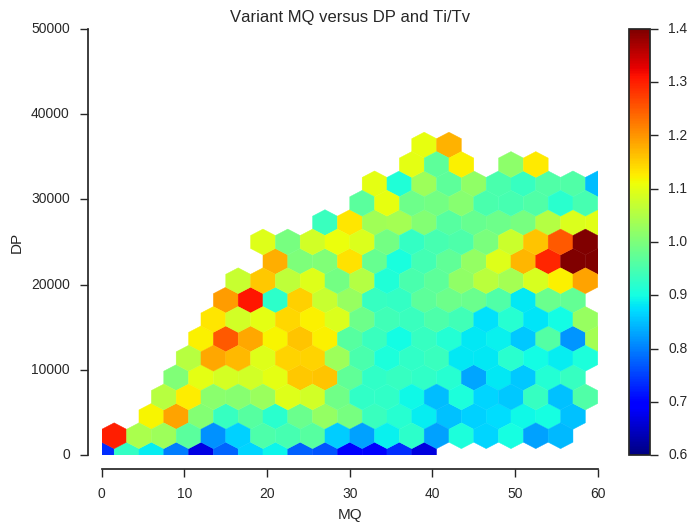

In [28]:
plot_joint_ti_tv('MQ', 'DP', downsample=5, mincnt=400, extent=(0, 60, 0, 50000))

This information may be useful when designing a variant filtering strategy. If you have other data that could be used as a quality indicator, such as Mendelian errors in a trio or cross, and/or data on genotype discordances between replicate samples, a similar analysis could be performed.

## Filtering variants

There are many possible approaches to filtering variants. The simplest approach is define thresholds on variant attributes like DP, MQ and QD, and exclude SNPs that fall outside of a defined range (a.k.a. "hard filtering"). This is crude but simple to implement and in many cases may suffice, at least for an initial exploration of the data. 

Let's implement a simple hard filter. First, a reminder that we have a table containing all these variant attributes.

In [29]:
variants

<VariantChunkedTable shape=(16437135,) dtype=[('POS', '<i4'), ('REF', 'S1'), ('ALT', 'S1', (3,)), ('DP', '<i4'), ('MQ', '<f2'), ('QD', '<f2'), ('num_alleles', 'u1')]
   nbytes=266.5M cbytes=116.8M cratio=2.3
   values=h5py._hl.group.Group>

Define the hard filter using an expression. This is just a string of Python code, which we will evaluate in a moment.

In [30]:
filter_expression = '(QD > 5) & (MQ > 40) & (DP > 15000) & (DP < 30000)'

Now evaluate the filter using the columns from the table

In [31]:
variant_selection = variants.eval(filter_expression)[:]
variant_selection

array([False, False, False, ..., False, False, False], dtype=bool)

How many variants to we keep?

In [32]:
np.count_nonzero(variant_selection)

11766616

How many variants do we filter out?

In [33]:
np.count_nonzero(~variant_selection)

4670519

Now that we have our variant filter, let's make a new variants table with only rows for variants that pass our filter.

In [34]:
variants_pass = variants.compress(variant_selection)
variants_pass

<VariantChunkedTable shape=(11766616,) dtype=[('POS', '<i4'), ('REF', 'S1'), ('ALT', 'S1', (3,)), ('DP', '<i4'), ('MQ', '<f2'), ('QD', '<f2'), ('num_alleles', 'u1')]
   nbytes=190.8M cbytes=93.0M cratio=2.1
   values=allel.chunked.storage_zarr.ZarrTable>

## Subset genotypes

Now that we have some idea of variant quality, let's look at our samples and at the genotype calls.

All data relating to the genotype calls is stored in the HDF5.

In [35]:
calldata = callset[chrom]['calldata']
calldata

<HDF5 group "/3L/calldata" (5 members)>

In [36]:
list(calldata.keys())

['AD', 'DP', 'GQ', 'genotype', 'is_called']

Each of these is a separate dataset in the HDF5 file. To make it easier to work with the genotype dataset, let's wrap it using a class from scikit-allel.

In [37]:
genotypes = allel.GenotypeChunkedArray(calldata['genotype'])
genotypes

<GenotypeChunkedArray shape=(16437135, 765, 2) dtype=int8 chunks=(6553, 10, 2)
   nbytes=23.4G cbytes=1.2G cratio=19.1
   compression=gzip compression_opts=3
   values=h5py._hl.dataset.Dataset>

N.B., at this point we have not loaded any data into memory, it is still in the HDF5 file. From the representation above we have some diagnostic information about the genotypes, for example, we have calls for 16,437,135 variants in 765 samples with ploidy 2 (i.e., diploid). Uncompressed these data would be 23.4G but the data are compressed and so actually use 1.2G on disk.

We can also see genotype calls for the first 5 variants in the first and last 5 samples, which are all missing ("./.").

Before we go any furter, let's also pull in some data about the 765 samples we've genotyped.

In [38]:
samples_fn = 'data/2016-06-10/samples.meta.txt'
samples = pandas.DataFrame.from_csv(samples_fn, sep='\t')
samples.head()

ox_code src_code sra_sample_accession population       country region  \
index                                                                           
0      AB0085-C    BF2-4            ERS223996        BFS  Burkina Faso   Pala   
1      AB0087-C    BF3-3            ERS224013        BFM  Burkina Faso   Bana   
2      AB0088-C    BF3-5            ERS223991        BFM  Burkina Faso   Bana   
3      AB0089-C    BF3-8            ERS224031        BFM  Burkina Faso   Bana   
4      AB0090-C   BF3-10            ERS223936        BFM  Burkina Faso   Bana   

       contributor         contact  year m_s sex  n_sequences  mean_coverage  \
index                                                                          
0      Austin Burt  Sam O'Loughlin  2012   S   F     89905852          28.01   
1      Austin Burt  Sam O'Loughlin  2012   M   F    116706234          36.76   
2      Austin Burt  Sam O'Loughlin  2012   M   F    112090460          23.30   
3      Austin Burt  Sam O'Loughlin  2012   M   F    145350454          41.36   
4      Austin Burt  Sam O'Loughlin  2012   M   F    105012254          34.64   

       latitude  longitude  
index                       
0        11.150     -4.235  
1        11.233     -4.472  
2        11.233     -4.472  
3        11.233     -4.472  
4        11.233     -4.472

The "population" column defines which of 9 populations the mosquitoes came from, based on sampling location and species. E.g., "BFM" means *Anopheles coluzzii* mosquitoes from Burkina Faso, "GAS" means *Anopheles gambiae* mosquitoes from Gabon. How many mosquitoes come from each of these populations?

In [39]:
samples.population.value_counts()

CMS    275
UGS    103
BFS     81
BFM     69
AOM     60
GAS     56
GWA     46
KES     44
GNS     31
Name: population, dtype: int64

Let's work with two populations only for simplicity. These are *Anopheles coluzzii* populations from Burkina Faso (BFM) and Angola (AOM).

In [40]:
sample_selection = samples.population.isin({'BFM', 'AOM'}).values
sample_selection[:5]

array([False,  True,  True,  True,  True], dtype=bool)

Now restrict the samples table to only these two populations.

In [41]:
samples_subset = samples[sample_selection]
samples_subset.reset_index(drop=True, inplace=True)
samples_subset.head()

ox_code src_code sra_sample_accession population       country region  \
0  AB0087-C    BF3-3            ERS224013        BFM  Burkina Faso   Bana   
1  AB0088-C    BF3-5            ERS223991        BFM  Burkina Faso   Bana   
2  AB0089-C    BF3-8            ERS224031        BFM  Burkina Faso   Bana   
3  AB0090-C   BF3-10            ERS223936        BFM  Burkina Faso   Bana   
4  AB0091-C   BF3-12            ERS224065        BFM  Burkina Faso   Bana   

   contributor         contact  year m_s sex  n_sequences  mean_coverage  \
0  Austin Burt  Sam O'Loughlin  2012   M   F    116706234          36.76   
1  Austin Burt  Sam O'Loughlin  2012   M   F    112090460          23.30   
2  Austin Burt  Sam O'Loughlin  2012   M   F    145350454          41.36   
3  Austin Burt  Sam O'Loughlin  2012   M   F    105012254          34.64   
4  Austin Burt  Sam O'Loughlin  2012   M   F     98833426          29.97   

   latitude  longitude  
0    11.233     -4.472  
1    11.233     -4.472  
2    11.233     -4.472  
3    11.233     -4.472  
4    11.233     -4.472

In [42]:
samples_subset.population.value_counts()

BFM    69
AOM    60
Name: population, dtype: int64

Now let's subset the genotype calls to keep only variants that pass our quality filters and only samples in our two populations of interest.

In [43]:
%%time
genotypes_subset = genotypes.subset(variant_selection, sample_selection)

CPU times: user 3min 5s, sys: 1.5 s, total: 3min 6s
Wall time: 3min 9s


This takes a couple of minutes, so time for a quick tea break.

In [44]:
genotypes_subset

<GenotypeChunkedArray shape=(11766616, 129, 2) dtype=int8 chunks=(2873, 129, 2)
   nbytes=2.8G cbytes=174.7M cratio=16.6
   compression=blosc compression_opts={'clevel': 5, 'shuffle': 1, 'cname': 'lz4'}
   values=zarr.core.Array>

The new genotype array we've made has 11,766,616 SNPs and 129 samples, as expected.

## Sample QC

Before we go any further, let's do some sample QC. This is just to check if any of the 129 samples we're working with have major quality issues that might confound an analysis. 

Compute the percent of missing and heterozygous genotype calls for each sample.

In [45]:
%%time
n_variants = len(variants_pass)
pc_missing = genotypes_subset.count_missing(axis=0)[:] * 100 / n_variants
pc_het = genotypes_subset.count_het(axis=0)[:] * 100 / n_variants

CPU times: user 46 s, sys: 996 ms, total: 47 s
Wall time: 38.8 s


Define a function to plot genotype frequencies for each sample.

In [46]:
def plot_genotype_frequency(pc, title):
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.despine(ax=ax, offset=10)
    left = np.arange(len(pc))
    palette = sns.color_palette()
    pop2color = {'BFM': palette[0], 'AOM': palette[1]}
    colors = [pop2color[p] for p in samples_subset.population]
    ax.bar(left, pc, color=colors)
    ax.set_xlim(0, len(pc))
    ax.set_xlabel('Sample index')
    ax.set_ylabel('Percent calls')
    ax.set_title(title)
    handles = [mpl.patches.Patch(color=palette[0]),
               mpl.patches.Patch(color=palette[1])]
    ax.legend(handles=handles, labels=['BFM', 'AOM'], title='Population',
              bbox_to_anchor=(1, 1), loc='upper left')

Let's look at missingness first.

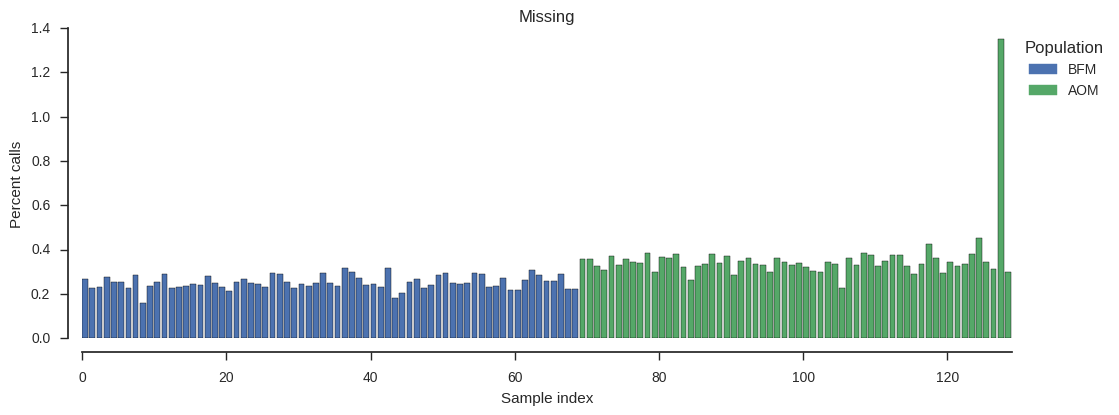

In [47]:
plot_genotype_frequency(pc_missing, 'Missing')

There is one sample with higher missingness than the others. Which one is it?

In [48]:
np.argsort(pc_missing)[-1]

127

Let's dig a little more into this sample. Is the excess missingness spread over the whole genome, or only in a specific region? Choose two other samples to compare with.

In [49]:
g_strange = genotypes_subset.take([60, 100, 127], axis=1)
g_strange

<GenotypeChunkedArray shape=(11766616, 3, 2) dtype=int8 chunks=(45964, 3, 2)
   nbytes=67.3M cbytes=6.2M cratio=10.8
   compression=blosc compression_opts={'clevel': 5, 'shuffle': 1, 'cname': 'lz4'}
   values=zarr.core.Array>

Locate missing calls.

In [50]:
is_missing = g_strange.is_missing()[:]
is_missing

array([[False, False, False],
       [False, False, False],
       [False, False, False],
       ..., 
       [False, False, False],
       [False, False, False],
       [False, False, False]], dtype=bool)

Plot missingness for each sample over the chromosome.

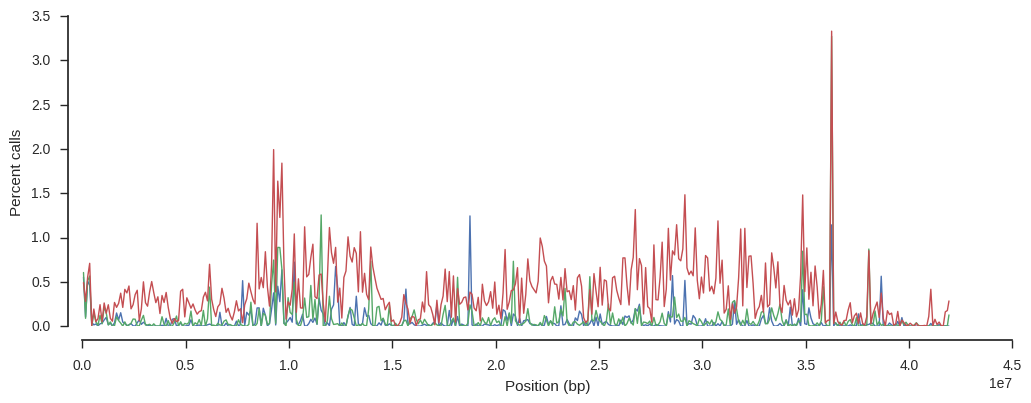

In [51]:
pos = variants_pass['POS'][:]
window_size = 100000
y1, windows, _ = allel.stats.windowed_statistic(pos, is_missing[:, 0], statistic=np.count_nonzero, size=window_size)
y2, windows, _ = allel.stats.windowed_statistic(pos, is_missing[:, 1], statistic=np.count_nonzero, size=window_size)
y3, windows, _ = allel.stats.windowed_statistic(pos, is_missing[:, 2], statistic=np.count_nonzero, size=window_size)
x = windows.mean(axis=1)
fig, ax = plt.subplots(figsize=(12, 4))
sns.despine(ax=ax, offset=10)
ax.plot(x, y1 * 100 / window_size, lw=1)
ax.plot(x, y2 * 100 / window_size, lw=1)
ax.plot(x, y3 * 100 / window_size, lw=1)
ax.set_xlabel('Position (bp)')
ax.set_ylabel('Percent calls');

The sample with higher missingness (in red) has generally higher missingness over the whole chromosome. 

Let's look at heterozygosity.

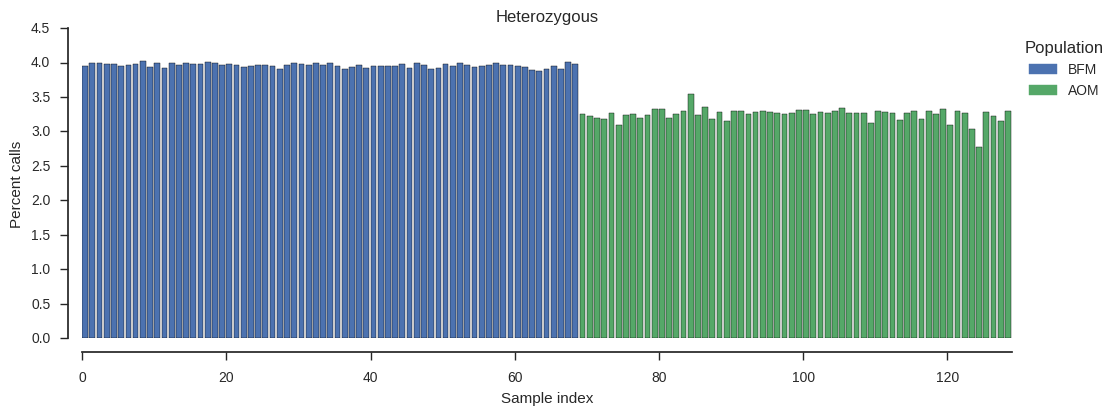

In [52]:
plot_genotype_frequency(pc_het, 'Heterozygous')

No samples stand out, although it looks like there is a general trend for lower heterozogysity in the AOM population.

The level of missingness in sample 127 is higher than other samples but not that high in absolute terms, so let's leave it in for now.

## Allele count

As a first step into doing some population genetic analyses, let's perform an allele count within each of the two populations we've selected. This just means, for each SNP, counting how many copies of the reference allele (0) and each of the alternate alleles (1, 2, 3) are observed.

To set this up, define a dictionary mapping population names onto the indices of samples within them.

In [53]:
subpops = {
    'all': list(range(len(samples_subset))),
    'BFM': samples_subset[samples_subset.population == 'BFM'].index.tolist(),
    'AOM': samples_subset[samples_subset.population == 'AOM'].index.tolist(),
}
subpops['AOM'][:5]

[69, 70, 71, 72, 73]

Now perform the allele count.

In [54]:
%%time
ac_subpops = genotypes_subset.count_alleles_subpops(subpops, max_allele=3)

CPU times: user 37.3 s, sys: 2.01 s, total: 39.3 s
Wall time: 22.2 s


In [55]:
ac_subpops

<AlleleCountsChunkedTable shape=(11766616,) dtype=[('AOM', '<i4', (4,)), ('BFM', '<i4', (4,)), ('all', '<i4', (4,))]
   nbytes=538.6M cbytes=62.0M cratio=8.7
   values=allel.chunked.storage_zarr.ZarrTable>

Each column in the table above has allele counts for a population, where "all" means the union of both populations. We can pull out a single column, e.g.:

In [56]:
ac_subpops['AOM'][:5]

<AlleleCountsArray shape=(5, 4) dtype=int32>
120   0   0   0
120   0   0   0
120   0   0   0
120   0   0   0
118   2   0   0

So in the AOM population, at the fifth variant (index 4) we observe 118 copies of the reference allele (0) and 2 copies of the first alternate allele (1).

## Locate segregating variants

There are lots of SNPs which do not segregate in either of these populations are so are not interesting for any analysis of these populations. We might as well get rid of them.

How many segregating SNPs are there in each population?

In [57]:
for pop in 'all', 'BFM', 'AOM':
    print(pop, ac_subpops[pop].count_segregating())

all 5240001
BFM 4695733
AOM 2099287


Locate SNPs that are segregating in the union of our two selected populations.

In [58]:
is_seg = ac_subpops['all'].is_segregating()[:]
is_seg

array([False, False, False, ..., False, False, False], dtype=bool)

Subset genotypes again to keep only the segregating SNPs.

In [59]:
genotypes_seg = genotypes_subset.compress(is_seg, axis=0)
genotypes_seg

<GenotypeChunkedArray shape=(5240001, 129, 2) dtype=int8 chunks=(2559, 129, 2)
   nbytes=1.3G cbytes=161.5M cratio=8.0
   compression=blosc compression_opts={'clevel': 5, 'shuffle': 1, 'cname': 'lz4'}
   values=zarr.core.Array>

Subset the variants and allele counts too.

In [60]:
variants_seg = variants_pass.compress(is_seg)
variants_seg

<VariantChunkedTable shape=(5240001,) dtype=[('POS', '<i4'), ('REF', 'S1'), ('ALT', 'S1', (3,)), ('DP', '<i4'), ('MQ', '<f2'), ('QD', '<f2'), ('num_alleles', 'u1')]
   nbytes=85.0M cbytes=43.2M cratio=2.0
   values=allel.chunked.storage_zarr.ZarrTable>

In [61]:
ac_seg = ac_subpops.compress(is_seg)
ac_seg

<AlleleCountsChunkedTable shape=(5240001,) dtype=[('AOM', '<i4', (4,)), ('BFM', '<i4', (4,)), ('all', '<i4', (4,))]
   nbytes=239.9M cbytes=39.6M cratio=6.1
   values=allel.chunked.storage_zarr.ZarrTable>

## Population differentiation

Are these two populations genetically different? To get a first impression, let's plot the alternate allele counts from each population.

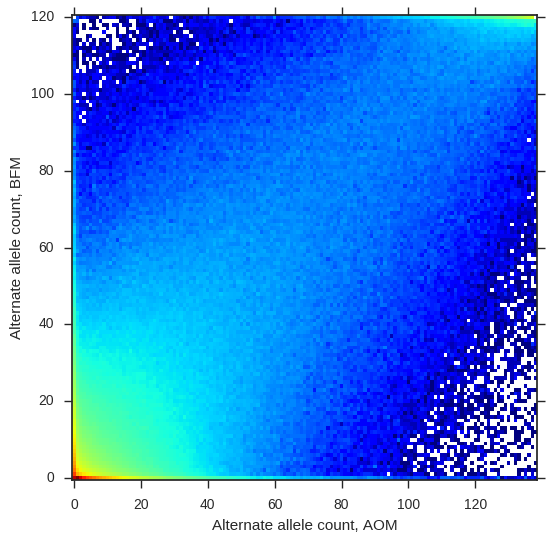

In [62]:
jsfs = allel.stats.joint_sfs(ac_seg['BFM'][:, 1], ac_seg['AOM'][:, 1])
fig, ax = plt.subplots(figsize=(6, 6))
allel.stats.plot_joint_sfs(jsfs, ax=ax)
ax.set_ylabel('Alternate allele count, BFM')
ax.set_xlabel('Alternate allele count, AOM');

So the alternate allele counts are correlated, meaning there is some relationship between these two populations, however there are plenty of SNPs off the diagonal, suggesting there is also some differentiation.

Let's compute average Fst, a statistic which summarises the difference in allele frequencies averaged over all SNPs. This also includes an estimate of standard error via jacknifing in blocks of 100,000 SNPs.

In [63]:
fst, fst_se, _, _ = allel.stats.blockwise_hudson_fst(ac_seg['BFM'], ac_seg['AOM'], blen=100000)
print("Hudson's Fst: %.3f +/- %.3f" % (fst, fst_se))

Hudson's Fst: 0.109 +/- 0.006


Define a function to plot Fst in windows over the chromosome.

In [64]:
def plot_fst(ac1, ac2, pos, blen=2000):
    
    fst, se, vb, _ = allel.stats.blockwise_hudson_fst(ac1, ac2, blen=blen)
    
    # use the per-block average Fst as the Y coordinate
    y = vb
    
    # use the block centres as the X coordinate
    x = allel.stats.moving_statistic(pos, statistic=lambda v: (v[0] + v[-1]) / 2, size=blen)
    
    # plot
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.despine(ax=ax, offset=10)
    ax.plot(x, y, 'k-', lw=.5)
    ax.set_ylabel('$F_{ST}$')
    ax.set_xlabel('Chromosome %s position (bp)' % chrom)
    ax.set_xlim(0, pos.max())

Are any chromosome regions particularly differentiated?

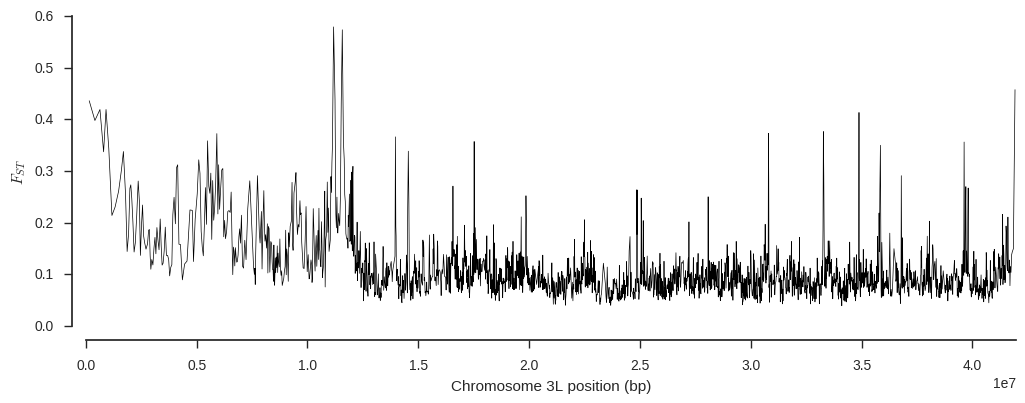

In [65]:
plot_fst(ac_seg['BFM'], ac_seg['AOM'], variants_seg['POS'][:])

It looks like there could be an interesting signal of differentiation around 11Mbp. In fact I happen to know from other analyses that signal is driven by evolution in genes involved in the mosquito's immune response to parasites, first described in [White et al. (2011)](http://www.ncbi.nlm.nih.gov/pubmed/21173248).

There are a number of subtleties to Fst analysis which I haven't mentioned here, but you can read more about [estimating Fst](http://alimanfoo.github.io/2015/09/21/estimating-fst.html) on my blog.

## Site frequency spectra

While we're looking at allele counts, let's also plot a site frequency spectrum for each population, which gives another summary of the data and is also informative about demographic history.

To do this we really do need to restrict to biallelic SNPs, so let's do that first.

In [66]:
is_biallelic_01 = ac_seg['all'].is_biallelic_01()[:]
ac1 = ac_seg['BFM'].compress(is_biallelic_01, axis=0)[:, :2]
ac2 = ac_seg['AOM'].compress(is_biallelic_01, axis=0)[:, :2]
ac1

array([[138,   0],
       [  1, 137],
       [137,   1],
       ..., 
       [136,   0],
       [135,   1],
       [136,   0]], dtype=int32)

OK, now plot folded site frequency spectra, scaled such that populations with constant size should have a spectrum close to horizontal (constant across allele frequencies).

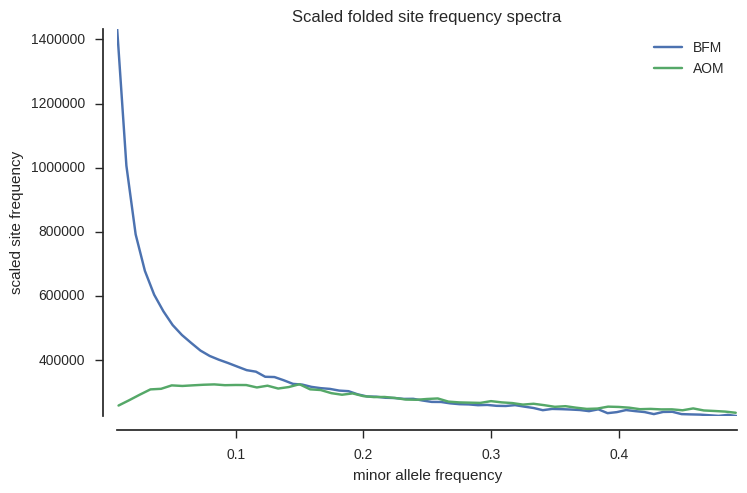

In [67]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.despine(ax=ax, offset=10)
sfs1 = allel.stats.sfs_folded_scaled(ac1)
allel.stats.plot_sfs_folded_scaled(sfs1, ax=ax, label='BFM', n=ac1.sum(axis=1).max())
sfs2 = allel.stats.sfs_folded_scaled(ac2)
allel.stats.plot_sfs_folded_scaled(sfs2, ax=ax, label='AOM', n=ac2.sum(axis=1).max())
ax.legend()
ax.set_title('Scaled folded site frequency spectra')
# workaround bug in scikit-allel re axis naming
ax.set_xlabel('minor allele frequency');

The spectra are very different for the two populations. BFM has an excess of rare variants, suggesting a population expansion, while AOM is closer to neutral expectation, suggesting a more stable population size.

We can also plot Tajima's D, which is a summary of the site frequency spectrum, over the chromosome, to see if there are any interesting localised variations in this trend.

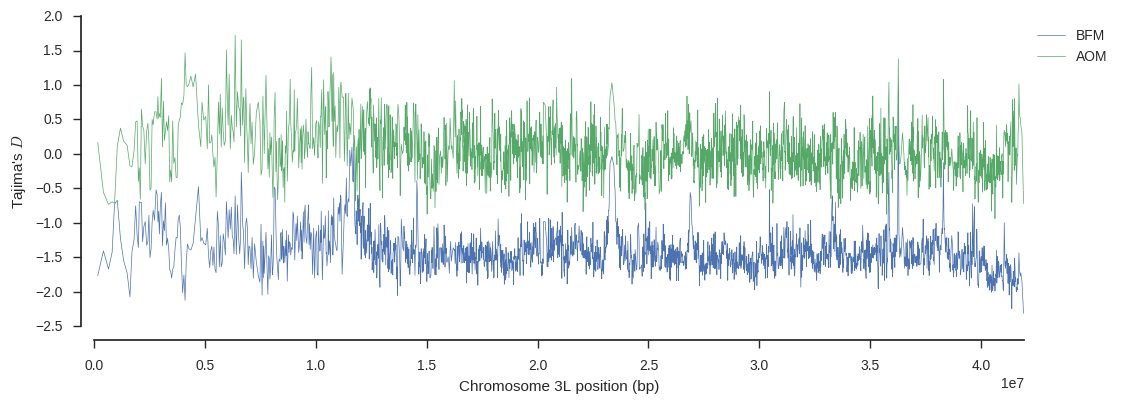

In [68]:
# compute windows with equal numbers of SNPs
pos = variants_seg['POS'][:]
windows = allel.stats.moving_statistic(pos, statistic=lambda v: [v[0], v[-1]], size=2000)
x = np.asarray(windows).mean(axis=1)

# compute Tajima's D
y1, _, _ = allel.stats.windowed_tajima_d(pos, ac_seg['BFM'][:], windows=windows)
y2, _, _ = allel.stats.windowed_tajima_d(pos, ac_seg['AOM'][:], windows=windows)

# plot
fig, ax = plt.subplots(figsize=(12, 4))
sns.despine(ax=ax, offset=10)
ax.plot(x, y1, lw=.5, label='BFM')
ax.plot(x, y2, lw=.5, label='AOM')
ax.set_ylabel("Tajima's $D$")
ax.set_xlabel('Chromosome %s position (bp)' % chrom)
ax.set_xlim(0, pos.max())
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));

Again there is an interesting signal around 11Mbp on BFM, suggesting some history of selection at that locus.

## Principal components analysis

Finally, let's to a quick-and-dirty PCA to confirm our evidence for differentiation between these two populations and check if there is any other genetic structure within populations that we might have missed.

First grab the allele counts for the union of the two populations.

In [69]:
ac = ac_seg['all'][:]
ac

<AlleleCountsArray shape=(5240001, 4) dtype=int32>
256   2   0   0
 86 172   0   0
244  14   0   0
...
234  22   0   0
151 105   0   0
253   3   0   0

Select the variants to use for the PCA, including only biallelic SNPs with a minor allele count above 2.

In [70]:
pca_selection = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 2)
pca_selection

array([False,  True,  True, ...,  True,  True,  True], dtype=bool)

In [71]:
np.count_nonzero(pca_selection)

2058611

Now randomly downsample these SNPs purely for speed.

In [72]:
indices = np.nonzero(pca_selection)[0]
indices

array([      1,       2,       4, ..., 5239998, 5239999, 5240000])

In [73]:
len(indices)

2058611

In [74]:
indices_ds = np.random.choice(indices, size=50000, replace=False)
indices_ds.sort()
indices_ds

array([    156,     168,     242, ..., 5239421, 5239616, 5239887])

Subset the genotypes to keep only our selected SNPs for PCA.

In [75]:
genotypes_pca = genotypes_seg.take(indices_ds, axis=0)
genotypes_pca

<GenotypeChunkedArray shape=(50000, 129, 2) dtype=int8 chunks=(782, 129, 2)
   nbytes=12.3M cbytes=2.5M cratio=4.9
   compression=blosc compression_opts={'clevel': 5, 'shuffle': 1, 'cname': 'lz4'}
   values=zarr.core.Array>

Transform the genotypes into an array of alternate allele counts per call. 

In [76]:
gn = genotypes_pca.to_n_alt()[:]
gn

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

Run the PCA.

In [77]:
coords, model = allel.stats.pca(gn)

In [78]:
coords.shape

(129, 10)

Plot the results.

In [79]:
def plot_pca_coords(coords, model, pc1, pc2, ax):
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop in ['BFM', 'AOM']:
        flt = (samples_subset.population == pop).values
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', label=pop, markersize=6)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))

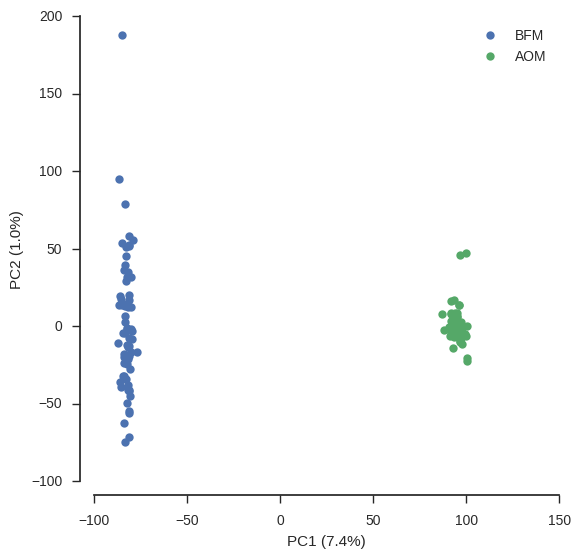

In [80]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax)
ax.legend();

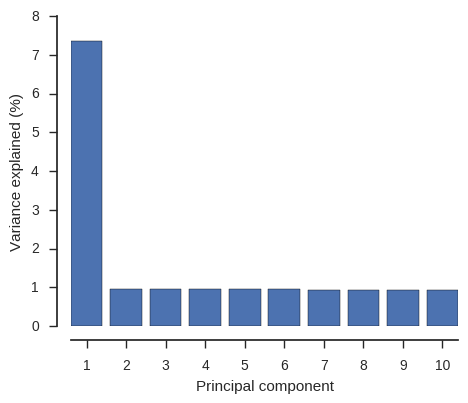

In [81]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.despine(ax=ax, offset=10)
y = 100 * model.explained_variance_ratio_
x = np.arange(len(y))
ax.set_xticks(x + .4)
ax.set_xticklabels(x + 1)
ax.bar(x, y)
ax.set_xlabel('Principal component')
ax.set_ylabel('Variance explained (%)');

From this PCA we can see that only PC1 contains any information and this separates the two populations, so we have confirmed there is no other structure within these populations that needs to be taken into account.

For running PCA with more populations there are a number of subtleties which I haven't covered here, for all the gory details see the [fast PCA](http://alimanfoo.github.io/2015/09/28/fast-pca.html) article on my blog.

## Under the hood

Here's a few notes on what's going on under the hood. If you want to know more, the best place to look is the [scikit-allel source code](https://github.com/cggh/scikit-allel).

### NumPy arrays

NumPy is the foundation for everything in scikit-allel. A NumPy array is an N-dimensional container for binary data.

In [82]:
x = np.array([0, 4, 7])
x

array([0, 4, 7])

In [83]:
x.ndim

1

In [84]:
x.shape

(3,)

In [85]:
x.dtype

dtype('int64')

In [86]:
# item access
x[1]

4

In [87]:
# slicing
x[0:2]

array([0, 4])

NumPy support array-oriented programming, which is both convenient and efficient, because looping is implemented internally in C code. 

In [88]:
y = np.array([1, 6, 9])
x + y

array([ 1, 10, 16])

Scikit-allel defines a number of conventions for storing variant call data using NumPy arrays. For example, a set of diploid genotype calls over *m* variants in *n* samples is stored as a NumPy array of integers with shape (m, n, 2). 

In [89]:
g = allel.GenotypeArray([[[0, 0], [0, 1]],
                         [[0, 1], [1, 1]],
                         [[0, 2], [-1, -1]]], dtype='i1')
g

<GenotypeArray shape=(3, 2, 2) dtype=int8>
0/0 0/1
0/1 1/1
0/2 ./.

The ``allel.GenotypeArray`` class is a sub-class of ``np.ndarray``.

In [90]:
isinstance(g, np.ndarray)

False

All the usual properties and methods of an ndarray are inherited.

In [91]:
g.ndim

3

In [92]:
g.shape

(3, 2, 2)

In [93]:
# obtain calls for the second variant in all samples
g[1, :]

<GenotypeVector shape=(2, 2) dtype=int8>
0/1 1/1

In [94]:
# obtain calls for the second sample in all variants
g[:, 1]

<GenotypeVector shape=(3, 2) dtype=int8>
0/1 1/1 ./.

In [95]:
# obtain the genotype call for the second variant, second sample
g[1, 1]

array([1, 1], dtype=int8)

In [96]:
# make a subset with only the first and third variants
g.take([0, 2], axis=0)

<GenotypeArray shape=(2, 2, 2) dtype=int8>
0/0 0/1
0/2 ./.

In [97]:
# find missing calls
np.any(g < 0, axis=2)

array([[False, False],
       [False, False],
       [False,  True]], dtype=bool)

Instances of ``allel.GenotypeArray`` also have some extra properties and methods. 

In [98]:
g.n_variants, g.n_samples, g.ploidy

(3, 2, 2)

In [99]:
g.count_alleles()

<AlleleCountsArray shape=(3, 3) dtype=int32>
3 1 0
1 3 0
1 0 1

### Chunked, compressed arrays

The ``scikit-allel`` genotype array convention is flexible, allowing for multiallelic and polyploid genotype calls. However, it is not very compact, requiring 2 bytes of memory for each call. A set of calls for 10,000,000 SNPs in 1,000 samples thus requires 20G of memory.

One option to work with large arrays is to use bit-packing, i.e., to pack two or more items of data into a single byte. E.g., this is what the [plink BED format](http://pngu.mgh.harvard.edu/~purcell/plink/binary.shtml) does. If you have have diploid calls that are only ever biallelic, then it is possible to fit 4 genotype calls into a single byte. This is 8 times smaller than the NumPy unpacked representation.

However, coding against bit-packed data is not very convenient. Also, there are several libraries available for Python which allow N-dimensional arrays to be stored using **compression**: [h5py](http://www.h5py.org/), [bcolz](http://bcolz.blosc.org/en/latest/) and [zarr](http://zarr.readthedocs.io). Genotype data is usually extremely compressible due to sparsity - most calls are homozygous ref, i.e., (0, 0), so there are a lot of zeros. 

For example, the ``genotypes`` data we used above has calls for 16 million variants in 765 samples, yet requires only 1.2G of storage. In other words, there are more than 9 genotype calls per byte, which means that each genotype call requires less than a single bit on average.

In [100]:
genotypes

<GenotypeChunkedArray shape=(16437135, 765, 2) dtype=int8 chunks=(6553, 10, 2)
   nbytes=23.4G cbytes=1.2G cratio=19.1
   compression=gzip compression_opts=3
   values=h5py._hl.dataset.Dataset>

The data for this array are stored in an HDF5 file on disk and compressed using zlib, and achieve a compression ratio of 19.1 over an equivalent uncompressed NumPy array.

To avoid having to decompress the entire dataset every time you want to access any part of it, the data are divided into chunks and each chunk is compressed. You have to choose the chunk shape, and there are some trade-offs regarding both the shape and size of a chunk. 

Here is the chunk shape for the ``genotypes`` dataset.

In [101]:
genotypes.chunks

(6553, 10, 2)

This means that the dataset is broken into chunks where each chunk has data for 6553 variants and 10 samples.

This gives a chunk size of ~128K (6553 \* 10 \* 2) which we have since found is not optimal - better performance is usually achieved with chunks that are at least 1M. However, performance is not bad and the data are publicly released so I haven't bothered to rechunk them.

Chunked, compressed arrays can be stored either on disk (as for the ``genotypes`` dataset) or in main memory. E.g., in the tour above, I stored all the intermediate genotype arrays in memory, such as the ``genotypes_subset`` array, which can speed things up a bit.

In [102]:
genotypes_subset

<GenotypeChunkedArray shape=(11766616, 129, 2) dtype=int8 chunks=(2873, 129, 2)
   nbytes=2.8G cbytes=174.7M cratio=16.6
   compression=blosc compression_opts={'clevel': 5, 'shuffle': 1, 'cname': 'lz4'}
   values=zarr.core.Array>

To perform some operation over a chunked arrays, the best way is to compute the result for each chunk separately then combine the results for each chunk if needed. All functions in ``scikit-allel`` try to use a chunked implementation wherever possible, to avoid having to load large data uncompressed into memory.

## Further reading


* [scikit-allel reference documentation](http://scikit-allel.readthedocs.io/)
* [Introducing scikit-allel](http://alimanfoo.github.io/2015/09/15/introducing-scikit-allel.html)
* [Estimating Fst](http://alimanfoo.github.io/2015/09/21/estimating-fst.html)
* [Fast PCA](http://alimanfoo.github.io/2015/09/28/fast-pca.html)
* [To HDF5 and beyond](http://alimanfoo.github.io/2016/04/14/to-hdf5-and-beyond.html)
* [CPU blues](http://alimanfoo.github.io/2016/05/16/cpu-blues.html)
* [vcfnp](https://github.com/alimanfoo/vcfnp)
* [numpy](http://www.numpy.org/)
* [matplotlib](http://matplotlib.org/)
* [pandas](http://pandas.pydata.org/)


In [103]:
import datetime
print(datetime.datetime.now().isoformat())

2016-11-01T20:12:59.720075
